In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [3]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
df_train['marker'] = 1
df_test['marker'] = 2
df_test['reviewer_score'] = 0
hotels = df_test.append(df_train, sort=False).reset_index(drop=True)

## Первичный анализ данных

In [5]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,marker,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,2,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,2,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,2,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,2,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,2,0.0


In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
#смотрим на количество пропусков в наших данных
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
marker                                           0
reviewer_score                                   0
dtype: int64

## Создание новых признаков и заполнение пропусков в данных

In [8]:
#Функция для кодирования признаков
import category_encoders as ce

def one_fot_encoding(df, column_name):
    encoder = ce.OneHotEncoder(cols=[column_name])
    type_bin = encoder.fit_transform(df[column_name])
    df = pd.concat([df, type_bin], axis=1)
    df.drop([column_name], axis=1, inplace=True) 
    
    return df

In [9]:
#Из признака "hotel_address" можно "вытащить" 2 новых признака - это признаки города и страны!
#Добавляем новый признак "Страны"

hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels.loc[hotels['hotel_country'] == 'Kingdom','hotel_country'] = 'United Kingdom'

#Добавляем новый признак "Города"

hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [10]:
#Вывод: Мы получили два новых признака. С помощью признака "hotel_city" и небольшой подготовки данных можно заполнить пропуски в данных: 
# "lat" и "lng".

In [11]:
#Заполняем пропуски в признаках 'lat' и 'lng'

values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

hotels['lat'] = hotels[['hotel_city','lat']].apply(lambda x: values_lat[x.hotel_city] if np.isnan(x.lat) else x.lat, axis=1)
hotels['lng'] = hotels[['hotel_city','lng']].apply(lambda x: values_lng[x.hotel_city] if np.isnan(x.lng) else x.lng, axis=1)

In [12]:
#Проверяем наши данные на пропуски и видим, что пропусков больше нет! Отлично!
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
marker                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
dtype: int64

In [13]:
#в задании 4.4 мы уже изменили признак tags и добавили новый признак "tags_new" -преобразовав его в список
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(re_func)

In [14]:
# Создадим множество из 20 самых часто встречаемых тегов

tags_counts = hotels.explode('tags')['tags'].value_counts()[:20]
df_tags_counts = pd.DataFrame(tags_counts).reset_index()
df_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(df_tags_counts['unique_tags'])

for tag in top_tags:
    tag_name = str(tag)
    hotels[tag_name] =  hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)

#Вывод: Теперь у нас появилось 20 новых колонок

In [15]:
#'review_date' переведем в формат datetime64
#и добавляем 2 новых признака: review_year и review_month
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

In [16]:
#Теперь исправим признак 'days_since_review': уберем из него слова days, оставим только числовые значения
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int')

In [17]:
#Теперь закодируем признаки hotel_city и hotel_country
hotels["hotel_country"] = hotels["hotel_country"].astype('category')
hotels["hotel_country_code"] = hotels["hotel_country"].cat.codes

hotels["hotel_city"] = hotels["hotel_city"].astype('category')
hotels["hotel_city_code"] = hotels["hotel_city"].cat.codes

#запомним в data_country коды стран в которых находятся наши отели
list_country = list(hotels[['hotel_country','hotel_country_code']]['hotel_country'].unique())
data_country = pd.DataFrame({'country':list_country,'country_code':0})
data_country['country_code'] = data_country['country'].apply(lambda x: hotels[hotels['hotel_country'] == x]['hotel_country_code'].mean().astype('int')) 

In [18]:
# Уберем лишние пробелы
def strip_text(text):
    try:
        return text.strip()
    except AttributeError:
        return text
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(strip_text)
hotels['reviewer_nationality']

# Закодируем
hotels["reviewer_nationality"] = hotels["reviewer_nationality"].astype('category')
hotels["reviewer_nationality_code"] = hotels["reviewer_nationality"].cat.codes

In [19]:
print ('Количество уникальных национальностей:',hotels['reviewer_nationality_code'].max())

Количество уникальных национальностей: 226


In [20]:
#исправим национальности тех кто из стран в которых есть отели. Что бы не было перемешки - сначала увеличим коды на 10.

hotels['reviewer_nationality_code'] = hotels['reviewer_nationality_code'] +10

# прогодился df_country 
dict_df_country = data_country.set_index('country').to_dict()['country_code']

for country, country_code in dict_df_country.items():
    hotels.loc[hotels['reviewer_nationality'] == country,['reviewer_nationality_code']] = country_code

In [21]:
# Закодируем hotel_name

hotels['hotel_name'] = hotels['hotel_name'].apply(strip_text)

hotels["hotel_name"] = hotels["hotel_name"].astype('category')
hotels["hotel_name_code"] = hotels["hotel_name"].cat.codes

In [22]:
#Нужно обработать признаки'negative_review','positive_review'.
#Обработаем их с помощью SentimentIntensityAnalyzer библиотеки VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Первым делов подправим явные выражения 
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

hotels['neg_scores'] = hotels['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
hotels['pos_scores'] = hotels['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].apply(lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].apply(lambda x: x['compound'])

In [23]:
# убираем нечисловые признаки
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

object_category = [s for s in hotels.columns if hotels[s].dtypes == 'category']
hotels.drop(object_category, axis = 1, inplace=True)

object_data = [s for s in hotels.columns if hotels[s].dtypes == 'datetime64[ns]']
hotels.drop(object_data, axis = 1, inplace=True)
#Мы убрали все нечисловые признаки из нашего датасета , тк модель не обучается на нечисловых признаках

In [24]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   marker                                      515738 non-null  int64  
 

In [25]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
            
X = df_train.drop(['reviewer_score'], axis=1)
Y = df_train['reviewer_score'] 

In [26]:
#Поделим все признаки на 2 группы :
# непрерывные признаки
num_cols = ['additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts', 
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'review_year',
            'n_review_sentiments_neg',
            'n_review_sentiments_neu',
            'n_review_sentiments_pos',
            'n_review_sentiments_compound',
            'p_review_sentiments_neg',
            'p_review_sentiments_neu',
            'p_review_sentiments_pos',
            'p_review_sentiments_compound'          
]

# категориальные признаки
cat_cols = ['Double Room',
            'Standard Double or Twin Room',
            'Group',
            'Deluxe Double Room',
            'Family with older children',
            'Family with young children',
            'Solo traveler',
            'Double or Twin Room',
            'Classic Double Room',
            'Stayed 1 night',
            'Stayed 2 nights',
            'Stayed 3 nights',
            'Stayed 4 nights',
            'Stayed 5 nights',
            'Leisure trip',
            'Submitted from a mobile device',
            'Superior Double Room',
            'Standard Double Room',
            'Business trip',
            'Couple',
            'hotel_country_code',
            'hotel_city_code',
            'review_year',
            'review_month', 
            'reviewer_nationality_code',
            'hotel_name_code'
]

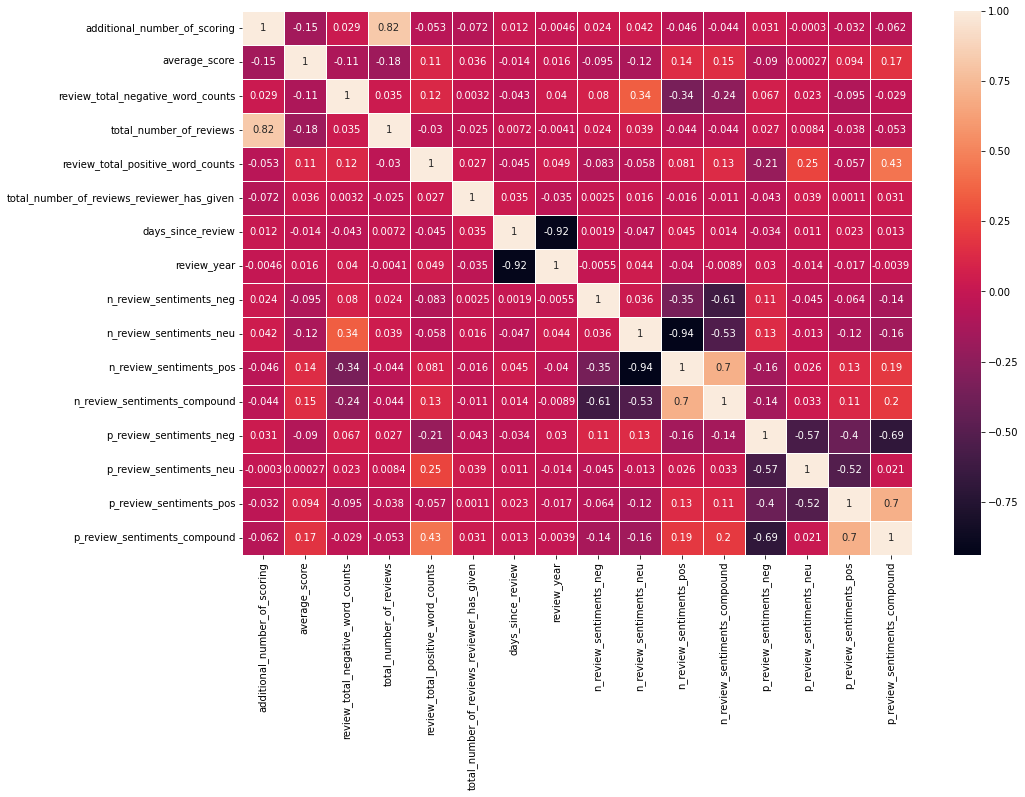

In [27]:
#Проведем корреляционный анализ с визуализацией для 2-х групп раздельно, что бы было удобнее.
#Первым проводим корреляционный анализ с визуализацией для непрерывных признаков
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels[num_cols].corr(method='pearson'), annot=True, linewidths=.5, ax=ax, fmt='.2g');

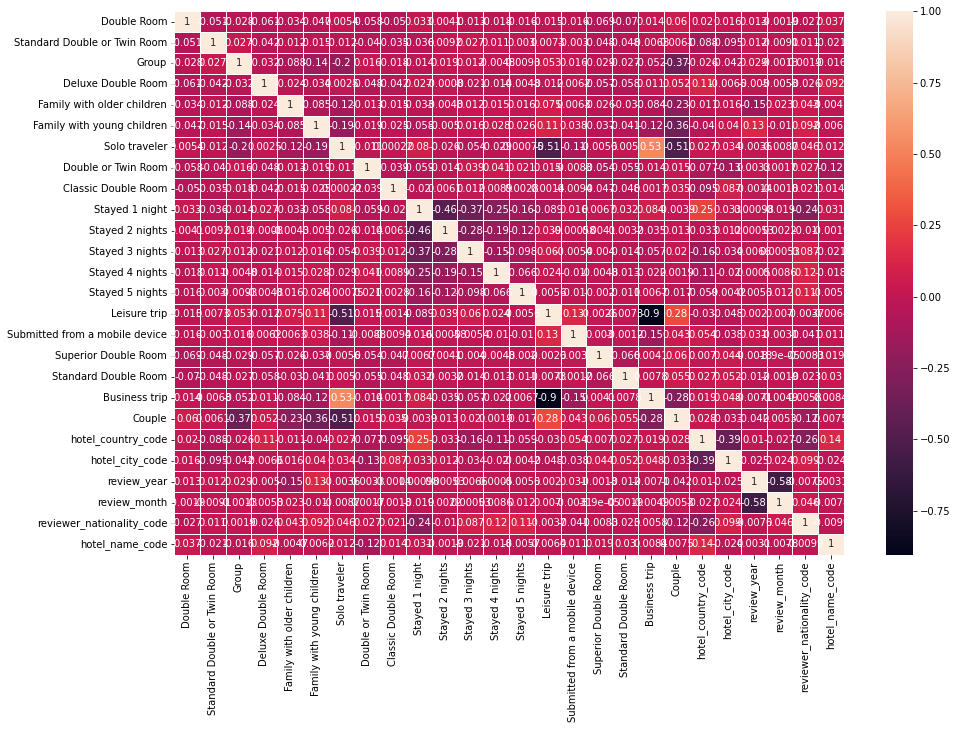

In [28]:
#используем корреляцию Спирмана для категориальных признаков
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels[cat_cols].corr(method = 'spearman'), annot=True, linewidths=.5, ax=ax, fmt='.2g');

In [29]:
drop_cols = ['additional_number_of_scoring', 'days_since_review', 'n_review_sentiments_neu','Business trip']

hotels.drop(drop_cols, axis = 1, inplace=True)

## Обучение модели и корректность наших предсказаний!

In [30]:
%%capture
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Определение констант для lightautoml
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600 # equal to 10 minutes
TARGET_NAME = 'reviewer_score'

# команды для максимальной воспроизводимости
np.random.seed(RANDOM_STATE)

In [31]:
# разбиение на тренировочную и валидационную модели
# tr_data - тренеровочные данные
# te_data - холдаут

tr_data, te_data = train_test_split(
    df_train, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# Для каждой из этих выборок мы знаем правильный ответ и сможем потом себя протестировать

In [32]:
# Task - объект из lightautoml
# Определяем какую задачу мы решаем: бинарную 'binary', регрессии 'reg', мультикласс 'multiclass'
# В данном случае регрессия - так как предсказываем вещественное число

task = Task('reg', loss = 'mae', metric = 'mae')

# какая колонка является целевой? и какие колонки лишние
roles = {
    'target': TARGET_NAME,
    'drop': []
}

# Создаем объект TabularAutoML

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)



# Начало обучения модели (на каких данных обучаем, какой target, уровень отображения)
# После выполнения обучения мы получаем Out OF Folde пердсказание

oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

# Информация о работе automl
# print(automl.create_model_str_desc())

[15:44:22] Stdout logging level is INFO.
[15:44:22] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[15:44:22] Task: reg

[15:44:22] Start automl preset with listed constraints:
[15:44:22] - time: 600.00 seconds
[15:44:22] - CPU: 4 cores
[15:44:22] - memory: 16 GB

[15:44:22] Train data shape: (309442, 18)

[15:44:32] Layer 1 train process start. Time left 590.50 secs
[15:44:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:45:16] Time limit exceeded after calculating fold 3

[15:45:16] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.9684297939692271
[15:45:16] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:45:16] Time left 546.16 secs

[15:45:50] Selector_LightGBM fitting and predicting completed
[15:46:11] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:47:05] Time limit exceeded after calculating fold 2

[15:47:05] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8642695943511511
[15:47:05] L

CPU times: user 134 ms, sys: 71 ms, total: 205 ms
Wall time: 96.2 ms


<AxesSubplot:xlabel='Feature'>

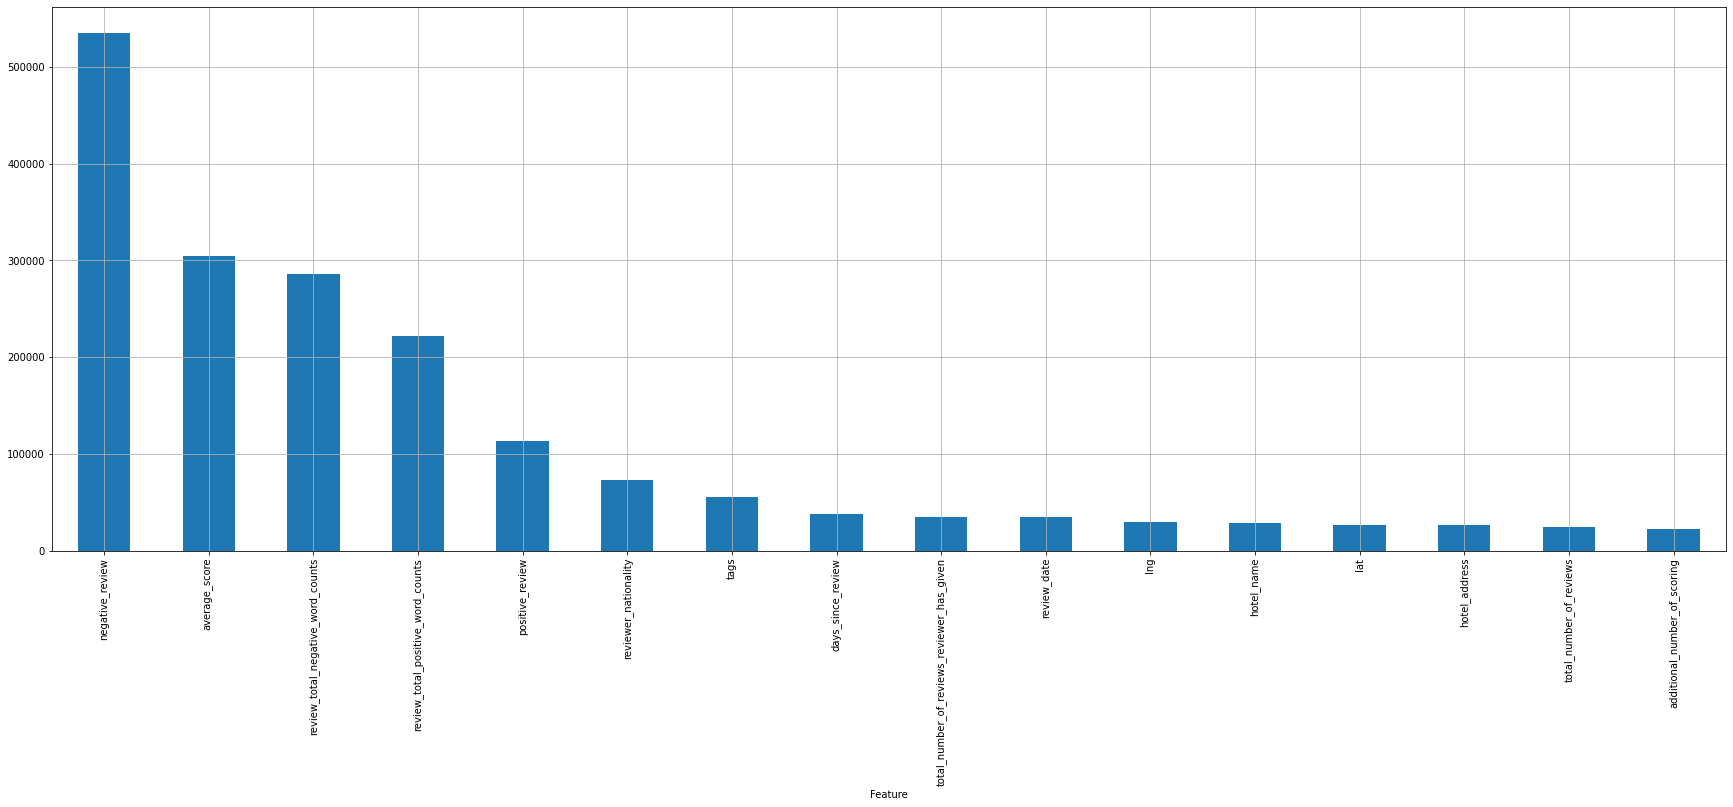

In [33]:
%%time

# Оцениваем важность признаков

fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True);

CPU times: user 3min 26s, sys: 324 ms, total: 3min 26s
Wall time: 1min 22s


<AxesSubplot:xlabel='Feature'>

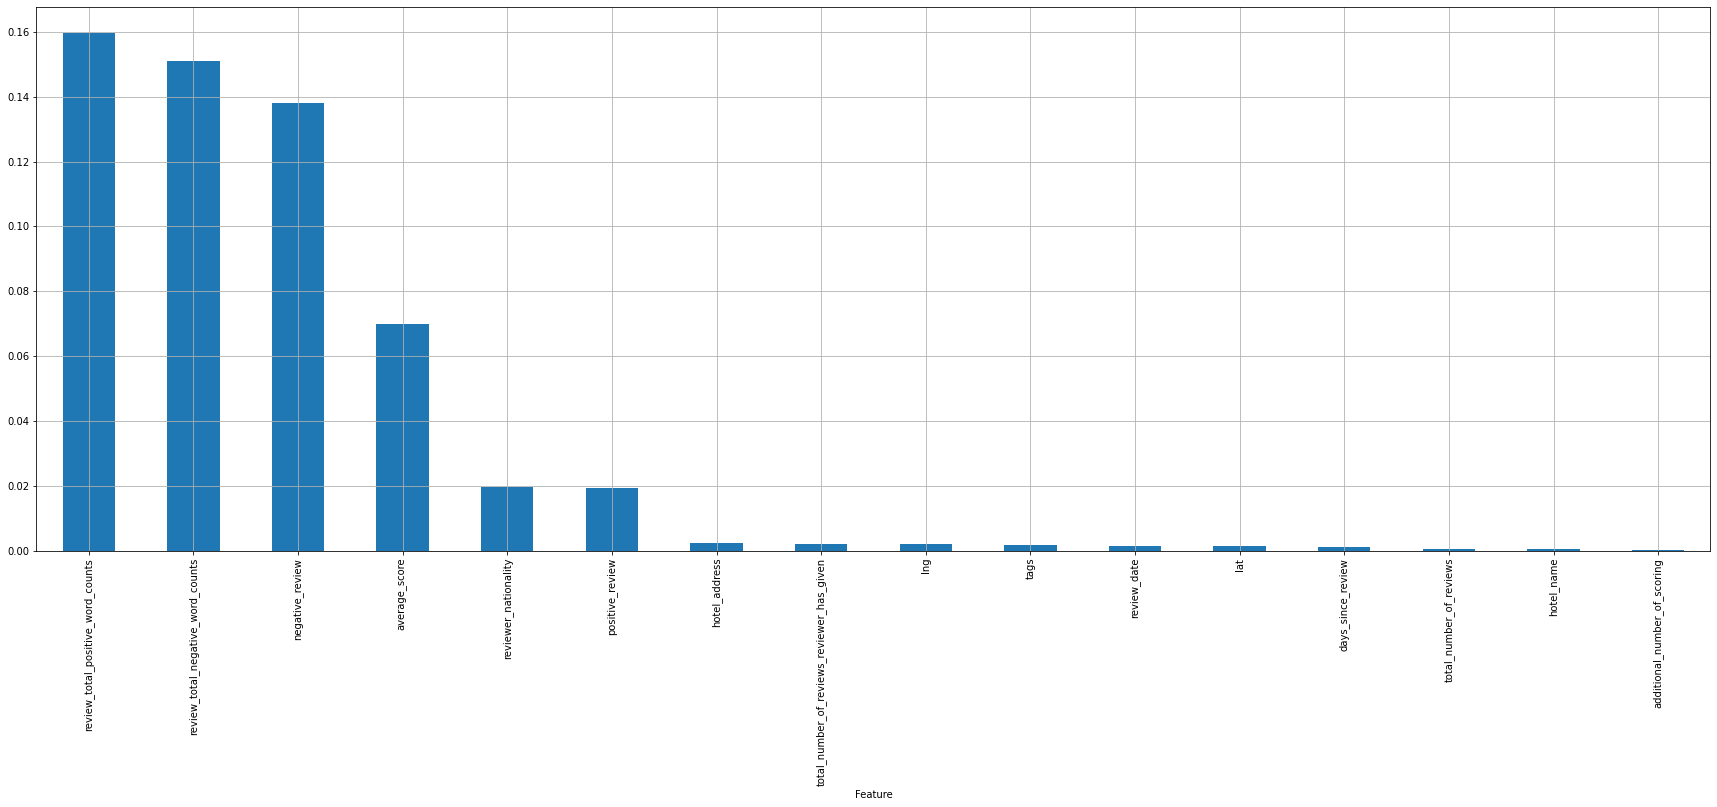

In [34]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True);

In [35]:
#Выводы:
#Самым сильным признаком в предсказании нашей модели является average_score - средний балл отеля
#Что вполне логично - не все отели накручивают рейтинги и этот парамерт важен
#Важны review_total_positive_word_counts и review_total_negative_word_counts 
#Новые признаки - n_review_sentiments_compound и p_review_sentiments_compound хорошо работают
#  - анализ сантимента текста отрабатывает вполне правдоподобно.


In [36]:
#Получаем предсказание на валидационой выборке с помощью функции automl.predict

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[5.7843094],
       [8.13604  ],
       [9.231881 ],
       ...,
       [8.237703 ],
       [8.313136 ],
       [7.4395123]], dtype=float32)
Shape = (77361, 1)


In [37]:
# Оцениваем модель 
# - сравниваем тренеровочные данные с правильными out-of-fold предсказаниями
# - и качество на холдаут выборке с теми предсказаниями которые мы на нее получили
from sklearn import metrics # инструменты для оценки точности модели  

#print(f'TRAIN  score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print('MAPE:', metrics.mean_absolute_percentage_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]))

MAPE: 0.12970570332905382


In [49]:
sample_submission['reviewer_score'] = test_pred

# Запишем предсказание в файл
sample_submission.to_csv('submission_01.csv', index = False)